In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import(
    ensemble,
    preprocessing,
    tree
)

In [2]:
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

In [3]:
from sklearn.model_selection import(
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score
)

In [4]:
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

In [5]:
from yellowbrick.model_selection import(
    learning_curve
)

# Titanic (Exemplo didático para fixação do conteúdo do curso de Scikit-Learn)
***
Neste exemplo queremos criar um modelo preditivo para responder a uma pergunta. Ele classificará se um indivíduo sobreviveu à catastrofe do navio Titanic com base nas características individuais e da viagem.

In [6]:
# url = "http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls"
file = "titanic3.xls"
df = pd.read_excel(file)
orig_df = df.copy()
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [7]:
df.shape

(1309, 14)

In [8]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [9]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


In [10]:
df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [11]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

### Calculando a porcentagem de valores ausentes no DataFrame
***

In [12]:
(df.isnull().sum()/df.shape[0]) * 100

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

As colunas com mais de 50% podem ser descartadas, pq seria um pouco complicado interpola-las para preencher os dados missing. 

In [13]:
df.drop(columns=['body', 'cabin', 'boat'], axis=1, inplace=True)
df.sample(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
927,3,0,"Khalil, Mr. Betros",male,NaN,1,0,2660,14.4542,C,NaN
909,3,1,"Jussila, Mr. Eiriik",male,32.0,0,0,STON/O 2. 3101286,7.9250,S,NaN
1103,3,0,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,S,NaN
1285,3,0,"Wenzel, Mr. Linhart",male,32.5,0,0,345775,9.5000,S,NaN
159,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,C,"Chicago, IL"
640,3,0,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,S,"Sweden Worcester, MA"
752,3,0,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,S,"West Bromwich, England Pontiac, MI"
655,3,0,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,S,"Ruotsinphytaa, Finland New York, NY"
219,1,1,"Omont, Mr. Alfred Fernand",male,NaN,0,0,F.C. 12998,25.7417,C,"Paris, France"
1057,3,1,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,C,NaN


In [14]:
mask=df.isnull().any(axis=1) # mascara para inspecionar algumas linhas com dados faltantes.
mask.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [15]:
df[mask].age.head()

13    26.0
15     NaN
18    32.0
23    42.0
24    29.0
Name: age, dtype: float64

In [16]:
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [17]:
pivot_gender_survived = pd.pivot_table(df, 
                                       values = ['survived'],
                                       index = 'sex',
                                       aggfunc=np.mean)
pivot_gender_survived

,survived
sex,
female,0.727468
male,0.190985


In [18]:
_ = df.groupby('survived').sex.value_counts().unstack(0).plot.barh()
plt.close()
plt.show()

In [19]:
df.embarked.value_counts(dropna=False) # dropna=False para incluir os dados faltantes

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

In [20]:
df.columns.tolist()

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'embarked',
 'home.dest']

In [21]:
df = df.drop(columns=['name', 'ticket', 'home.dest'])
df=pd.get_dummies(df, drop_first=True)

In [22]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [23]:
y=df.survived
X=df.drop(columns='survived')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Imputação dos dados ausentes
***

In [25]:
from sklearn.experimental import(
    enable_iterative_imputer
)
from sklearn import impute
num_cols=X.select_dtypes(include=['int64', 'float64']).columns
num_cols = ["pclass", "age", "sibsp", "parch", "sex_male", "fare"]

In [26]:
imputer = impute.IterativeImputer()
imputed=imputer.fit_transform(X_train[num_cols])
X_train.loc[:, num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

/home/fabio/projects/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/home/fabio/projects/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [27]:
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
   'embarked_Q', 'embarked_S']
sca = preprocessing.StandardScaler()
X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

## Refatorando o código
***

In [28]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [29]:
def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

In [30]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

## Modelo de base
***

In [31]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)  # accuracy

0.5699745547073791

In [32]:
from sklearn import metrics
metrics.precision_score(
    y_test, bm.predict(X_test)
)

/home/fabio/projects/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [33]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
)
import xgboost

In [35]:
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
    cls = model()
    kfold = KFold(
        n_splits=10, random_state=42, shuffle=True
    )
    s = cross_val_score(
        cls, X, y, scoring="roc_auc", cv=kfold
    )
    print(
        f"{model.__name__:22}  AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )

DummyClassifier         AUC: 0.500 STD: 0.00
LogisticRegression      AUC: 0.840 STD: 0.04
DecisionTreeClassifier  AUC: 0.751 STD: 0.04
KNeighborsClassifier    AUC: 0.825 STD: 0.03
GaussianNB              AUC: 0.811 STD: 0.05
SVC                     AUC: 0.838 STD: 0.03
RandomForestClassifier  AUC: 0.846 STD: 0.02
[06:33:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.

[06:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:33:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:33:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:33:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:33:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier           AUC: 0.854 STD: 0.02


/home/fabio/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [36]:
from mlxtend.classifier import (
    StackingClassifier,
)
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]
]
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(
    n_splits=10, random_state=42, shuffle =True
)
s = model_selection.cross_val_score(
    stack, X, y, scoring="roc_auc", cv=kfold
)
print(
    f"{stack.__class__.__name__}  "
    f"AUC: {s.mean():.3f}  STD: {s.std():.2f}"
)

StackingClassifier  AUC: 0.791  STD: 0.02


In [37]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100, random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
rf.score(X_test, y_test)

0.7837150127226463

In [39]:
metrics.precision_score(
    y_test, rf.predict(X_test)
)

0.7916666666666666

In [40]:
for col, val in sorted(
    zip(
        X_train.columns,
        rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")


age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


In [41]:
rf4 = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV(
    rf4, params, n_jobs=-1
).fit(X_train, y_train)
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [42]:
rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": "auto",
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.7073791348600509

In [43]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[217,   7],
       [108,  61]])

/home/fabio/projects/venv/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


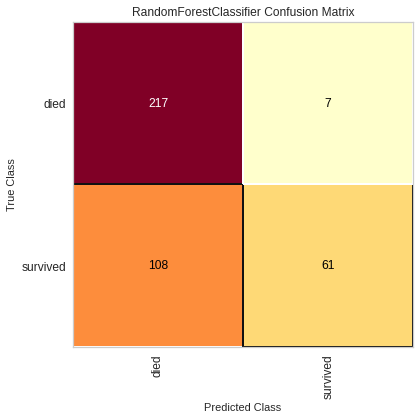

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [44]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf5,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

In [45]:
y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6648483727810651

/home/fabio/projects/venv/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


AttributeError: 'RandomForestClassifier' object has no attribute 'target_type_'

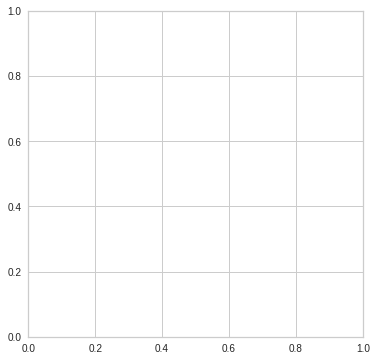

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(rf5)
roc_viz.score(X_test, y_test)
roc_viz.poof()

YellowbrickTypeError: Cannot detect the model name for non estimator: '<class 'pandas.core.frame.DataFrame'>'

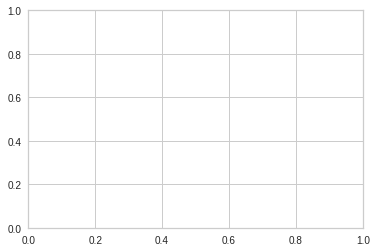

In [53]:
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = learning_curve(X,y,
    rf5,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X, y)
lc_viz.poof()

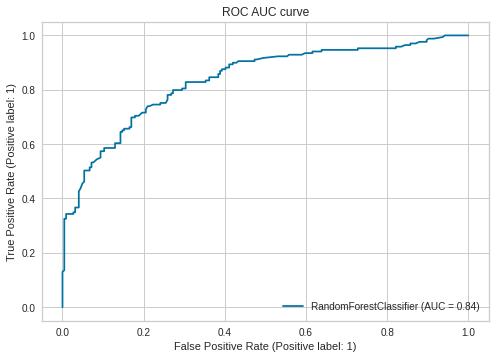

In [51]:
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(rf5, X_test, y_test)


_ = disp.ax_.set_title("ROC AUC curve")


# Persistência dos modelos
***

In [54]:
import pickle
pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)
y_pred = rf6.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6648483727810651